# US Consumer Finance Complaints

1. Data Analysis
    * Add word cloud per category analysis
2. Data Cleaning
3. Data Preprocessing (optional)
4. Preparing train, validation, and test datasets (Data API)
5. Modeling (Use tensorboard callback)
    * MultinomialNB (w/ gridsearchcv for hyperparameter tuning and k-fold cross-validation)
    * Logistic Regression
    * Linear Support Vector Machine
    * Random Forest
    * Simple Conv model
    * Universal sentence encoder model
    * BERT
6. Show results (model performances, model sizes)
7. Train best model on whole dataset (use earlystopping and tensorboard callback)
8. Show results of best model
9. Save model
10. Load model
11. Test model on ChatGPT-created sample complaints
12. Notes for improvement

In [1]:
# Importing the basic libraries we will require for the project

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing natural language processing libraries for processing text data
import nltk
import re

# Importing the Deep Learning models
# !pip install tensorflow==2.10
import tensorflow as tf

# Importing the other functions we may require from Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

# Code to ignore warnings from function usage
import warnings;
warnings.filterwarnings('ignore')

In [2]:
# Set a seed value
seed_value= 42
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
# Mount google drive to access dataset
# from google.colab import drive
# drive.mount('/content/drive')

# Load sample dataset from google drive
# path = "/content/drive/MyDrive/Data_Science_Projects/Finance_Complaints/data/complaints_sample.csv"
# complaints = pd.read_csv(path)

In [4]:
# Load sample dataset from google drive
path = "data/complaints_30k.csv"
complaints = pd.read_csv(path)

In [5]:
# Display first 5 rows of dataframe
complaints.head(20)

,consumer_complaint_narrative,product
0,"XXXX XXXX XXXX XXXX XXXX # XXXX Chicago, XXXX ...","Credit reporting, credit repair services, or o..."
1,Harvard Collection Services owned this debt wi...,Debt collection
2,Experian is reporting an account of mine as a ...,"Credit reporting, credit repair services, or o..."
3,This is basically a continuation of my CFPB ca...,Checking or savings account
4,You have listed incorrect accounts on my credi...,"Credit reporting, credit repair services, or o..."
5,See my previous complaints. I had asked to mov...,Credit card or prepaid card
6,"My identification was stolen in late XXXX, the...","Credit reporting, credit repair services, or o..."
7,OnXX/XX/XXXX we submitted a package to process...,Mortgage
8,CBNA has inquires on following dates that I do...,"Credit reporting, credit repair services, or o..."
9,"On XX/XX/XXXX, I received in the mail an offer...","Payday loan, title loan, or personal loan"


In [6]:
# Show dataframe shape (how many rows and columns)
complaints.shape

(33531, 2)

In [7]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  33531 non-null  object
 1   product                       33531 non-null  object
dtypes: object(2)
memory usage: 524.0+ KB


In [8]:
# Create X and y split
X = complaints['consumer_complaint_narrative']
y = complaints['product']

In [9]:
from sklearn.model_selection import train_test_split

# Create a function that creates a train, test, and validation split
def create_train_test_val_split(X, y, test_frac=0.2, val_frac=0.25, random_state=42):
    
    # Split training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=random_state, stratify=y)
    
    # Split training into training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_frac, random_state=random_state, stratify=y_train)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
# Create train, test, validation split
X_train, X_val, X_test, y_train, y_val, y_test = create_train_test_val_split(X, y)

In [11]:
# Check X shapes
X_train.shape, X_val.shape, X_test.shape

((20118,), (6706,), (6707,))

In [12]:
# Check y shapes
y_train.shape, y_val.shape, y_test.shape

((20118,), (6706,), (6707,))

In [13]:
# Check if product categories were stratified
y_train.value_counts(), y_test.value_counts(), y_val.value_counts()

(Credit reporting, credit repair services, or other personal consumer reports    9893
 Debt collection                                                                 3463
 Credit card or prepaid card                                                     1843
 Mortgage                                                                        1763
 Checking or savings account                                                      981
 Student loan                                                                     590
 Money transfer, virtual currency, or money service                               507
 Vehicle loan or lease                                                            358
 Payday loan, title loan, or personal loan                                        277
 Bank account or service                                                          268
 Consumer Loan                                                                    170
 Other financial service                              

In [14]:
# Convert text narratives into lists
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
X_val_list = X_val.tolist()

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Encode the labels with OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_oh = encoder.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_oh = encoder.fit_transform(y_test.to_numpy().reshape(-1,1))
y_val_oh = encoder.fit_transform(y_val.to_numpy().reshape(-1,1))

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels with LabelEncoder
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train.to_numpy()) 
y_test_enc = encoder.fit_transform(y_test.to_numpy()) # This will be used for testing model accuracy
y_val_enc = encoder.fit_transform(y_val.to_numpy())

# Get class names and number assignment from label encoder instance
class_names = encoder.classes_
num_classes = len(encoder.classes_)
class_names, num_classes

(array(['Bank account or service', 'Checking or savings account',
        'Consumer Loan', 'Credit card or prepaid card',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Debt collection',
        'Money transfer, virtual currency, or money service', 'Mortgage',
        'Other financial service',
        'Payday loan, title loan, or personal loan', 'Student loan',
        'Vehicle loan or lease'], dtype=object),
 12)

In [17]:
# Check y_train_oh
y_train_oh[:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
# Turn X and y into tensorslice datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_list, y_train_oh))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_list, y_test_oh))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_list, y_val_oh))

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-20 07:44:54.118680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 07:44:54.118809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
# Turn TensorSliceDatasets into prefetched data for faster processing
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset, val_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>)

### Modeling Experiments
0. Naive Bayes (Baseline)
1. Simple Dense
2. GRU
3. LSTM
4. Encoder-model
5. BERT

#### Model 0 (Baseline): Naive Bayes and Tf-idf

In [20]:
# Model 0 (Baseline): Naive Bayes and tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Build model
model_naive_bayes = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [21]:
# Fit model
model_naive_bayes.fit(X=X_train_list, y=y_train_enc)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate on val data
model_naive_bayes.score(X_val_list, y_val_enc)

0.5505517447062332

In [23]:
### Create function to calculate a model's accuracy, precision, recall, and f1 score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy * 100,
                  "precision": model_precision * 100,
                  "recall": model_recall * 100,
                  "f1": model_f1 * 100}
  return model_results

In [24]:
# Make predictions using model 1 on test data
preds_model_naive_bayes = model_naive_bayes.predict(X_test_list)

In [25]:
# Check results using 'calculate_results' function
results_model_naive_bayes = calculate_results(y_test_enc, preds_model_naive_bayes)
results_model_naive_bayes

{'accuracy': 55.10660503951096,
 'precision': 56.78709494717897,
 'recall': 55.10660503951096,
 'f1': 43.838438287107486}

#### Model: Simple Dense

##### Simple analysis of text data

In [26]:
# How long is each narrative on average?
narrative_lengths = [len(narrative.split()) for narrative in X_train_list]
avg_narrative_length = np.mean(narrative_lengths)
avg_narrative_length

183.45118799085395

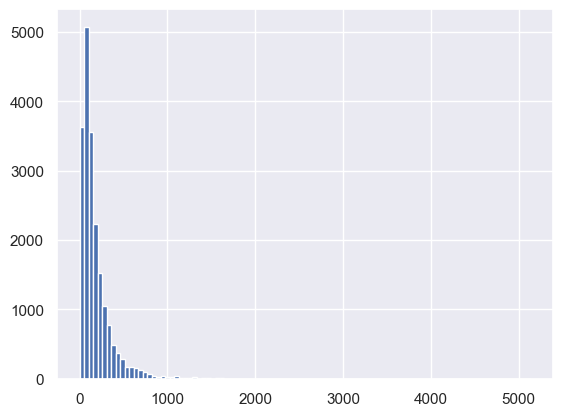

In [27]:
# What's the distribution of narrative lengths
plt.hist(narrative_lengths, bins=100)
plt.show()

* Distribution of narrative lengths is right-skewed

In [28]:
# What are the lengths of narratives at the 95th percentile
majority_narrative_length = int(np.percentile(narrative_lengths, 95))
majority_narrative_length # use for output sequence length of vectorize layer

551

In [29]:
# What is the max length of narrative in training data
max_narrative_length = max(narrative_lengths)
max_narrative_length

5137

In [30]:
from tensorflow.keras import layers

# Create text vectorizer layer to convert words to numbers
vectorize_layer = layers.TextVectorization(output_sequence_length=majority_narrative_length)

# Adapt vectorizer layer to text dataset
vectorize_layer.adapt(X_train_list)

2023-02-20 07:44:57.059862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 07:44:57.098797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [31]:
# Get vocabulary length
vocab_length = len(vectorize_layer.get_vocabulary())
vocab_length # Use in input_dim parameter of embedding layer

30099

In [32]:
# Test out text vectorizer on random narrative
import random
target_narrative = random.choice(X_train_list)
print(f"Text:\n{target_narrative}")
print(f"\nLength of Narrative: {len(target_narrative)}")
print(f"\nVectorized Narrative: {vectorize_layer([target_narrative])}")

Text:
Chase waited XXXX days to dishonor an item I deposited. When I called the Bank to complain I was given the royal run around and was given inaccurate information about the reason for the dishonor. My account has been debited for the amount of the deposit after XXXX days. Each time I asked for greater explanation the story changed.

Length of Narrative: 331

Vectorized Narrative: [[  254  1202     2    82     5  5523    36   388     4   849    67     4
     76     3    52     5  1697     4    12   333     3 19398   858   458
      6    12   333   151    30    90     3   340    20     3  5523     7
     23    35    37  2284    20     3    97     9     3   472    75     2
     82   263    71     4   125    20  3186   776     3  1572   674     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  

In [33]:
# Create embedding layer
embedding_layer = layers.Embedding(input_dim=vocab_length,
                                   output_dim=256,
                                   mask_zero=True, # for efficient computing
                                   name='token_embedding')

In [34]:
# Test out embedding layer
print(f"Target Narrative:\n{target_narrative}")
vec_narrative = vectorize_layer([target_narrative])
print(f"\nVectorized Narrative:\n{vec_narrative}")
embed_narrative = embedding_layer(vec_narrative)
print(f"\nEmbedded Narrative:\n{embed_narrative}")
print(f"\nShape of Embedded Narrative: {embed_narrative.shape}")

Target Narrative:
Chase waited XXXX days to dishonor an item I deposited. When I called the Bank to complain I was given the royal run around and was given inaccurate information about the reason for the dishonor. My account has been debited for the amount of the deposit after XXXX days. Each time I asked for greater explanation the story changed.

Vectorized Narrative:
[[  254  1202     2    82     5  5523    36   388     4   849    67     4
     76     3    52     5  1697     4    12   333     3 19398   858   458
      6    12   333   151    30    90     3   340    20     3  5523     7
     23    35    37  2284    20     3    97     9     3   472    75     2
     82   263    71     4   125    20  3186   776     3  1572   674     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0    

In [35]:
from tensorflow.keras import Model


# Build dense model
inputs = layers.Input(shape=(1,), dtype='string')
text_vectors = vectorize_layer(inputs) # vectorize text inputs
token_embeddings = embedding_layer(text_vectors) # create embedding
x = layers.Dense(128, activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x) # 1 node used since training on LebelEncoded data
model_dense = Model(inputs, outputs, name='Model_Dense')

# Compile model
model_dense.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy', 'categorical_accuracy'])

In [36]:
# Look at model details
model_dense.summary()

Model: "Model_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 551)              0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 551, 256)         7705344   
                                                                 
 dense (Dense)               (None, 551, 128)          32896     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 12)                

In [37]:
# Train the model
history_model_dense = model_dense.fit(train_dataset,
                                      steps_per_epoch=int(0.1*len(train_dataset)), # train on 10% of data for faster training
                                      epochs=3,
                                      validation_data=val_dataset,
                                      validation_steps=int(0.1*len(val_dataset))) # validate on only 10% of validation dataset fro faster feedback

Epoch 1/3


2023-02-20 07:44:58.386892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


61/62 [============================>.] - ETA: 0s - loss: 1.9643 - accuracy: 0.4652 - categorical_accuracy: 0.4652

2023-02-20 07:45:00.752636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 3s 39ms/step - loss: 1.9534 - accuracy: 0.4677 - categorical_accuracy: 0.4677 - val_loss: 1.5548 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643
Epoch 2/3
62/62 [==============================] - 2s 35ms/step - loss: 1.4422 - accuracy: 0.4965 - categorical_accuracy: 0.4965 - val_loss: 1.3360 - val_accuracy: 0.5491 - val_categorical_accuracy: 0.5491
Epoch 3/3
62/62 [==============================] - 2s 36ms/step - loss: 1.1784 - accuracy: 0.6532 - categorical_accuracy: 0.6532 - val_loss: 1.1658 - val_accuracy: 0.6488 - val_categorical_accuracy: 0.6488


In [38]:
### Create a function to plot loss curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

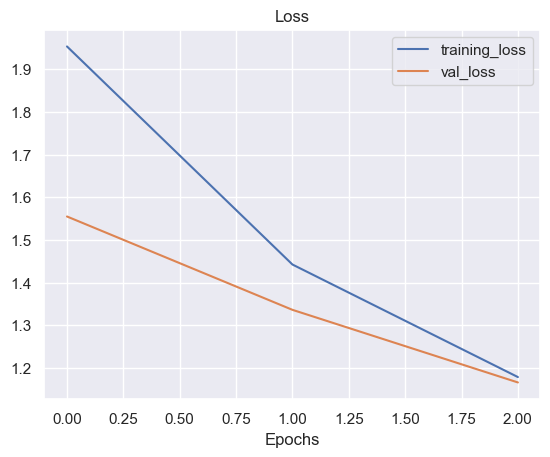

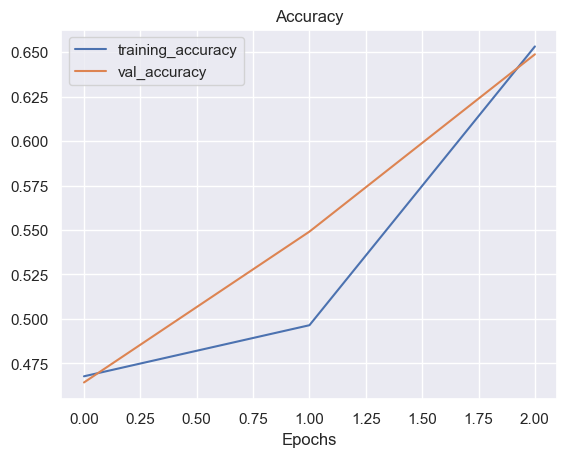

In [39]:
# Plot loss curves of dense model
plot_loss_curves(history_model_dense)

In [40]:
# Evaluate the model
model_dense.evaluate(test_dataset)

210/210 [==============================] - 2s 10ms/step - loss: 1.1331 - accuracy: 0.6577 - categorical_accuracy: 0.6577


[1.1330715417861938, 0.6576710939407349, 0.6576710939407349]

In [41]:
# Predict on test data
pred_probs_model_dense = model_dense.predict(test_dataset)
pred_probs_model_dense.shape, pred_probs_model_dense

 31/210 [===>..........................] - ETA: 0s

2023-02-20 07:45:07.783667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 1s 5ms/step


((6707, 12),
 array([[2.2622745e-02, 7.9994090e-02, 1.0554597e-02, ..., 1.7323870e-02,
         5.1673327e-02, 2.6241656e-02],
        [2.8761011e-03, 1.5528376e-02, 1.2595629e-03, ..., 2.7489099e-03,
         1.1394217e-02, 4.7013233e-03],
        [2.0422526e-02, 6.9776215e-02, 9.2396960e-03, ..., 1.2958575e-02,
         4.2257316e-02, 2.1743864e-02],
        ...,
        [1.8517701e-04, 1.3304050e-03, 9.8044809e-05, ..., 2.0333820e-04,
         7.6828327e-04, 4.4930982e-04],
        [6.8516484e-03, 3.1444654e-02, 3.2287114e-03, ..., 4.6627843e-03,
         1.8683426e-02, 9.2696398e-03],
        [5.7903912e-05, 5.8223866e-04, 2.8718723e-05, ..., 6.0656097e-05,
         2.8809745e-04, 1.3932429e-04]], dtype=float32))

In [42]:
# Convert prediction probabilities to classes
preds_model_dense = tf.argmax(pred_probs_model_dense, axis=1)
preds_model_dense

<tf.Tensor: shape=(6707,), dtype=int64, numpy=array([5, 4, 5, ..., 4, 5, 4])>

In [43]:
# Calculate results of model predictions on test data
results_model_dense = calculate_results(y_true=y_test_enc,
                                          y_pred=preds_model_dense)
results_model_dense

{'accuracy': 65.76710899060683,
 'precision': 56.072898161286645,
 'recall': 65.76710899060683,
 'f1': 59.757601890632536}

**NOTE**: Make a predict_and_calculate()

#### Model: Conv1D

In [44]:
# Build model
inputs = layers.Input(shape=(1,), dtype="string")
text_vectors = vectorize_layer(inputs)
token_embeddings = embedding_layer(text_vectors)
x = layers.Conv1D(128, kernel_size=5, activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_conv1d = Model(inputs, outputs, name='Model_Conv1D')

# Compile model
model_conv1d.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy', 'categorical_accuracy'])

In [45]:
# Fit model
history_model_conv1d = model_conv1d.fit(train_dataset,
                                            steps_per_epoch=int(0.1*len(train_dataset)),
                                            epochs=3,
                                            validation_data=val_dataset,
                                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3


2023-02-20 07:45:09.264897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 5s 82ms/step - loss: 1.9198 - accuracy: 0.4637 - categorical_accuracy: 0.4637 - val_loss: 2.4527 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643
Epoch 2/3


2023-02-20 07:45:14.320400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 2s 36ms/step - loss: 2.4198 - accuracy: 0.4849 - categorical_accuracy: 0.4849 - val_loss: 2.3855 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643
Epoch 3/3
62/62 [==============================] - 2s 36ms/step - loss: 2.3542 - accuracy: 0.4955 - categorical_accuracy: 0.4955 - val_loss: 2.3266 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643


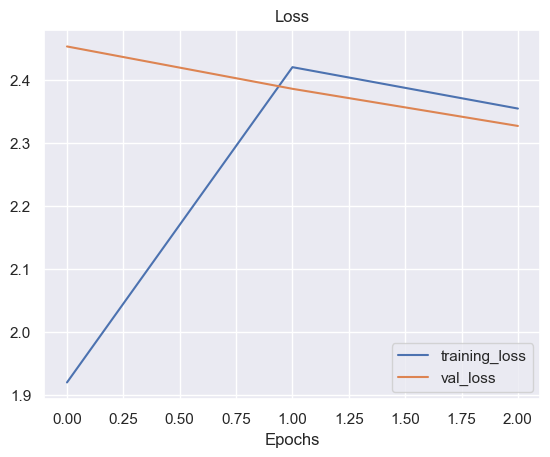

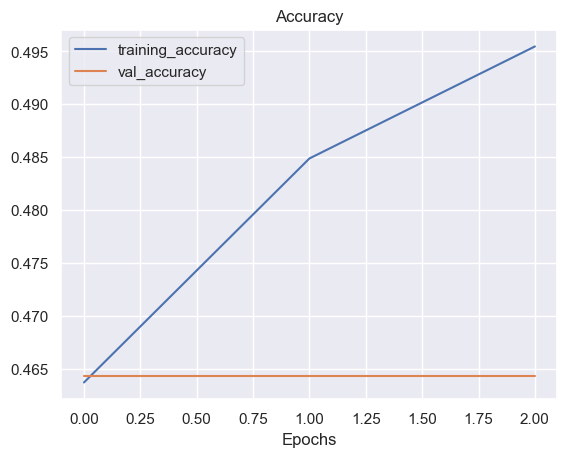

In [46]:
# Plot loss curves of dense model
plot_loss_curves(history_model_conv1d)

In [47]:
# Evaluate model
model_conv1d.evaluate(test_dataset)

210/210 [==============================] - 2s 8ms/step - loss: 2.3259 - accuracy: 0.4917 - categorical_accuracy: 0.4917


[2.3259189128875732, 0.4917250871658325, 0.4917250871658325]

In [48]:
# Predict on test data
pred_probs_model_conv1d = model_conv1d.predict(test_dataset)
pred_probs_model_conv1d.shape, pred_probs_model_conv1d

 26/210 [==>...........................] - ETA: 1s

2023-02-20 07:45:21.003492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 1s 5ms/step


((6707, 12),
 array([[0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ],
        [0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ],
        [0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ],
        ...,
        [0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ],
        [0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ],
        [0.07539202, 0.08094458, 0.07426913, ..., 0.07523756, 0.07685429,
         0.0756155 ]], dtype=float32))

In [49]:
# Convert prediction probabilities to classes
preds_model_conv1d = tf.argmax(pred_probs_model_conv1d, axis=1)
preds_model_conv1d

<tf.Tensor: shape=(6707,), dtype=int64, numpy=array([4, 4, 4, ..., 4, 4, 4])>

In [50]:
# Calculate results of Model 2 RNN predictions on test data
results_model_conv1d = calculate_results(y_true=y_test_enc,
                                          y_pred=preds_model_conv1d)
results_model_conv1d

{'accuracy': 49.17250633666318,
 'precision': 24.17935379429181,
 'recall': 49.17250633666318,
 'f1': 32.417976191567256}

#### Model: Conv1D and Dense

In [51]:
# Build model
inputs = layers.Input(shape=(1,), dtype='string')
text_vectors = vectorize_layer(inputs)
token_embeddings = embedding_layer(text_vectors)

x = layers.Conv1D(kernel_size=64, filters=8, activation='relu')(token_embeddings)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(32, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model_conv1d_dense = Model(inputs, outputs, name="Model_Conv1d_Dense")

# Compile model
model_conv1d_dense.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy', 'categorical_accuracy'])

In [52]:
# Fit model
history_model_conv1d_dense = model_conv1d_dense.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3


2023-02-20 07:45:22.532455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 2.4564 - accuracy: 0.4728 - categorical_accuracy: 0.4728

2023-02-20 07:45:25.765563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 4s 57ms/step - loss: 2.4564 - accuracy: 0.4728 - categorical_accuracy: 0.4728 - val_loss: 2.4277 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643
Epoch 2/3
62/62 [==============================] - 3s 54ms/step - loss: 2.4025 - accuracy: 0.4849 - categorical_accuracy: 0.4849 - val_loss: 2.3740 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643
Epoch 3/3
62/62 [==============================] - 3s 55ms/step - loss: 2.3468 - accuracy: 0.4955 - categorical_accuracy: 0.4955 - val_loss: 2.3222 - val_accuracy: 0.4643 - val_categorical_accuracy: 0.4643


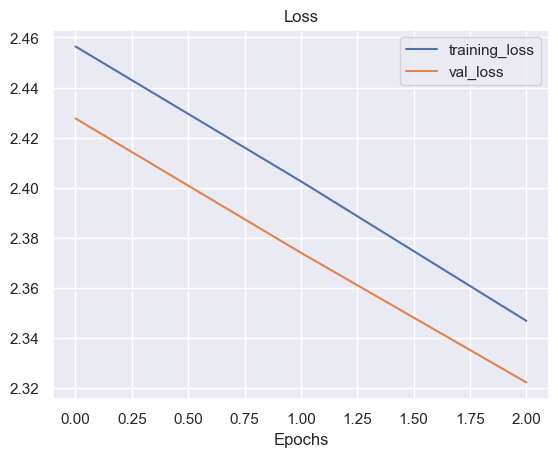

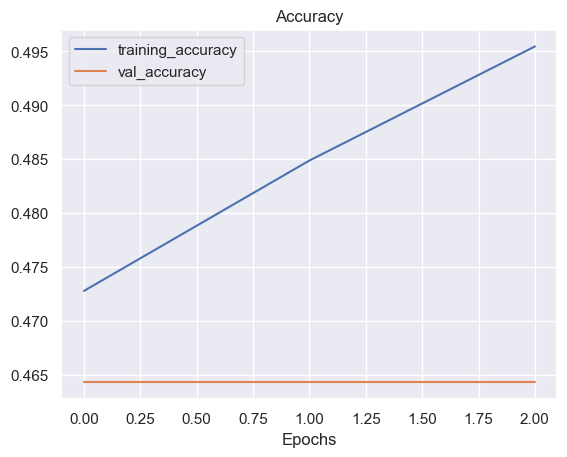

In [53]:
# Plot loss curves of dense model
plot_loss_curves(history_model_conv1d_dense)

In [54]:
# Evaluate model
model_conv1d_dense.evaluate(test_dataset)

210/210 [==============================] - 4s 19ms/step - loss: 2.3218 - accuracy: 0.4917 - categorical_accuracy: 0.4917


[2.3218038082122803, 0.4917250871658325, 0.4917250871658325]

In [55]:
# Predict on test data
pred_probs_model_conv1d_dense = model_conv1d_dense.predict(X_test_list)

# Get labels of pred probs
preds_model_conv1d_dense = tf.argmax(pred_probs_model_conv1d_dense, axis=1)

# Calculate results
results_model_conv1d_dense = calculate_results(y_pred=preds_model_conv1d_dense,
                                    y_true=y_test_enc)

  9/210 [>.............................] - ETA: 3s

2023-02-20 07:45:37.559809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 3s 14ms/step


In [56]:
# Display results
results_model_conv1d_dense

{'accuracy': 49.17250633666318,
 'precision': 24.17935379429181,
 'recall': 49.17250633666318,
 'f1': 32.417976191567256}

For final results section, display:
* all scores in graph
* param sizes

#### Model: Pretrained Embedding Layer (Universal Sentence Encoder)

In [57]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

2023-02-20 07:45:43.325567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [58]:
# Build model
inputs = layers.Input(shape=[], dtype='string')
embedded_inputs = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation='relu')(embedded_inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model_use_dense = Model(inputs, outputs, name="Model_USE_Dense")

# Compile model
model_use_dense.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

In [59]:
# Fit model
history_model_use_dense = model_use_dense.fit(train_dataset,
                                                  steps_per_epoch=int(0.1*len(train_dataset)),
                                                  epochs=3,
                                                  validation_data=val_dataset,
                                                  validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3


2023-02-20 07:45:46.375591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 1.7817 - accuracy: 0.4985

2023-02-20 07:45:52.240546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 9s 127ms/step - loss: 1.7817 - accuracy: 0.4985 - val_loss: 1.2789 - val_accuracy: 0.6190
Epoch 2/3
62/62 [==============================] - 7s 115ms/step - loss: 1.0861 - accuracy: 0.6598 - val_loss: 0.9688 - val_accuracy: 0.7188
Epoch 3/3
62/62 [==============================] - 6s 105ms/step - loss: 0.8756 - accuracy: 0.7364 - val_loss: 0.8922 - val_accuracy: 0.7321


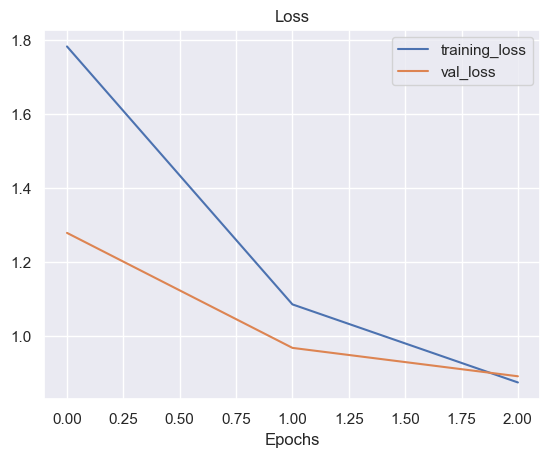

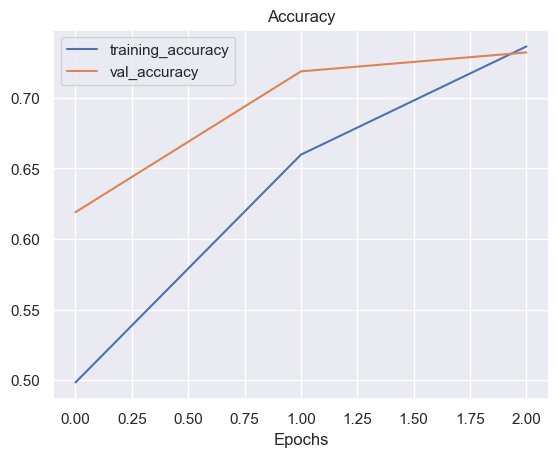

In [60]:
# Plot loss curves of dense model
plot_loss_curves(history_model_use_dense)

In [61]:
# Evaluate model on test_dataset
model_use_dense.evaluate(test_dataset)

210/210 [==============================] - 22s 104ms/step - loss: 0.8676 - accuracy: 0.7276


[0.8675665855407715, 0.7275980710983276]

In [62]:
# Predict on test_dataset
pred_probs_model_use_dense = model_use_dense.predict(X_test_list)

# Get labels of predictions
preds_model_use_dense = tf.argmax(pred_probs_model_use_dense, axis=1)

# Calculate results
results_model_use_dense = calculate_results(y_pred=preds_model_use_dense,
                                              y_true=y_test_enc)

2023-02-20 07:46:31.080352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 27s 128ms/step


In [63]:
# Display results
results_model_use_dense

{'accuracy': 69.40509915014165,
 'precision': 60.85804182954468,
 'recall': 69.40509915014165,
 'f1': 64.01549769455352}

#### BERT Model

In [68]:
# Set BERT model encoder and Preprocessing model handles
BERT_model_encoder_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
preprocess_model_handle = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [69]:
# Initialize preprocess model
bert_preprocess_model = hub.KerasLayer(preprocess_model_handle)

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on Mikkaels-MacBook-Air.local. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
# Build BERT classifier model
def build_BERT_classifier_model():
  inputs = layers.Input(shape=(), dtype='string', name='text_inputs')
  preprocessing_layer = hub.KerasLayer(preprocess_model_handle, name='preprocesing')
  encoder_inputs = preprocessing_layer(inputs)
  encoder = hub.KerasLayer(BERT_model_encoder_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = layers.Dropout(0.1)(net)
  net = layers.Dense(num_classes, activation='softmax', name='BERT_classifier')(net)
  return Model(inputs, net)

In [ ]:
# Instantiate a BERT model
BERT_model_0 = build_BERT_classifier_model()

In [ ]:
# Check model structure
tf.keras.utils.plot_model(BERT_model_0)

In [ ]:
# Compile model
BERT_model_0.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy', 'categorical_accuracy'])

In [ ]:
# Fit model
history_BERT_model_0 = BERT_model_0.fit(train_dataset,
                                        steps_per_epoch=int(0.1*len(train_dataset)),
                                        epochs=3,
                                        validation_data=val_dataset,
                                        validation_steps=int(0.1*len(val_dataset)))

In [ ]:
# Plot loss curves of dense model
plot_loss_curves(history_BERT_model_0)

Model is getting stuck at 49.95% accuracy. Change optimizer to inprove performance.

In [ ]:
# Import optimization library for custom optimizer
from official.nlp import optimization

In [ ]:
### Create optimizer using AdamW (same optimizer BERT was originally trained on)

# Set optimizer parameters (initial learning rate, num of train steps, num of warmup steps)
init_lr = 3e-5
epochs = 3
steps_per_epoch = int(0.1*len(train_dataset))
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


# Create optimizer
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Initialize a new bert model
BERT_model_1 = build_BERT_classifier_model()

In [ ]:
# Compile BERT_model_1 using new optimizer
BERT_model_1.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy', 'categorical_accuracy'])

In [ ]:
# Fit model
history_BERT_model_1 = BERT_model_1.fit(train_dataset,
                                        steps_per_epoch=int(0.1*len(train_dataset)),
                                        epochs=epochs,
                                        validation_data=val_dataset,
                                        validation_steps=int(0.1*len(val_dataset)))

In [ ]:
# Plot loss curves of dense model
plot_loss_curves(history_BERT_model_1)

In [ ]:
# Evaluate model on test data
BERT_model_1.evaluate(test_dataset)

In [ ]:
# Predict on test dataset
pred_probs_BERT_model_1 = BERT_model_1.predict(X_test_list)

# Get labels of predictions
preds_BERT_model_1 = tf.argmax(pred_probs_BERT_model_1, axis=1)

# Calculate results
results_BERT_model_1 = calculate_results(y_pred=preds_BERT_model_1,
                                         y_true=y_test_enc)

In [ ]:
# Print results of BERT_model_1
results_BERT_model_1

Evaluate Models

In [63]:
### Create a dataframe that compiles all results of all models

# List down all results dicitonaries of each model
# model_results = [results_model_naive_bayes, results_model_lin_svc, results_model_rndm_forest, results_model_log_reg, results_gs_log_reg, results_model_dense, results_model_conv1d, results_model_conv1d_dense, results_model_use_dense, results_BERT_model_0, results_BERT_model_1]

# Create dataframe with all model results dictionaries
model_results = pd.DataFrame({'model_naive_bayes': results_model_naive_bayes,
                              # 'model_lin_svc': results_model_lin_svc,
                              # 'model_rndm_forest': results_model_rndm_forest,
                              # 'model_log_reg': results_model_log_reg,
                              # 'gs_log_reg': results_gs_log_reg,
                              'model_dense': results_model_dense,
                              'model_conv1d': results_model_conv1d,
                              'model_conv1d_dense': results_model_conv1d_dense,
                              'model_use_dense': results_model_use_dense,
                              #'model_BERT_0': results_BERT_model_0,
                              #'model_BERT_1': results_BERT_model_1
                              })

model_results = model_results.T
model_results

,accuracy,precision,recall,f1
model_naive_bayes,55.106605,56.787095,55.106605,43.838438
model_dense,65.767109,56.072898,65.767109,59.757602
model_conv1d,49.172506,24.179354,49.172506,32.417976
model_conv1d_dense,49.172506,24.179354,49.172506,32.417976
model_use_dense,72.759803,68.427634,72.759803,68.803007


<AxesSubplot: >

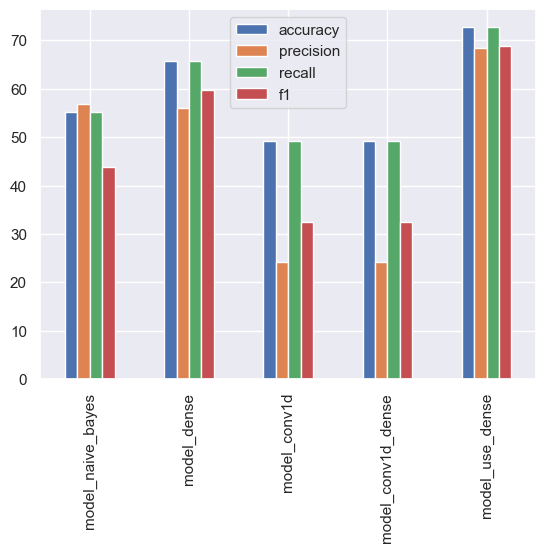

In [64]:
# Plot model results for better visualization
model_results.plot(kind='bar')

In [65]:
# Save model
model_use_dense.save('models/model_use_dense_0.h5')

In [66]:
from tensorflow.keras.models import load_model

# Load model and test on test data
loaded_model_use_dense = load_model('models/model_use_dense_0.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# Evaluate on test data
loaded_model_use_dense.evaluate(test_dataset)

2023-02-20 07:47:22.723348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 07:47:26.237897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 36s 171ms/step - loss: 0.8676 - accuracy: 0.7276


[0.8675665855407715, 0.7275980710983276]

In [67]:
# Predict on test data for confusion matrix
pred_probs_loaded_model = loaded_model_use_dense.predict(X_test_list)

2023-02-20 07:48:03.350744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 42s 197ms/step


[Text(154.74999999999997, 0.5, 'True'),
 Text(0.5, 44.249999999999986, 'Predicted')]

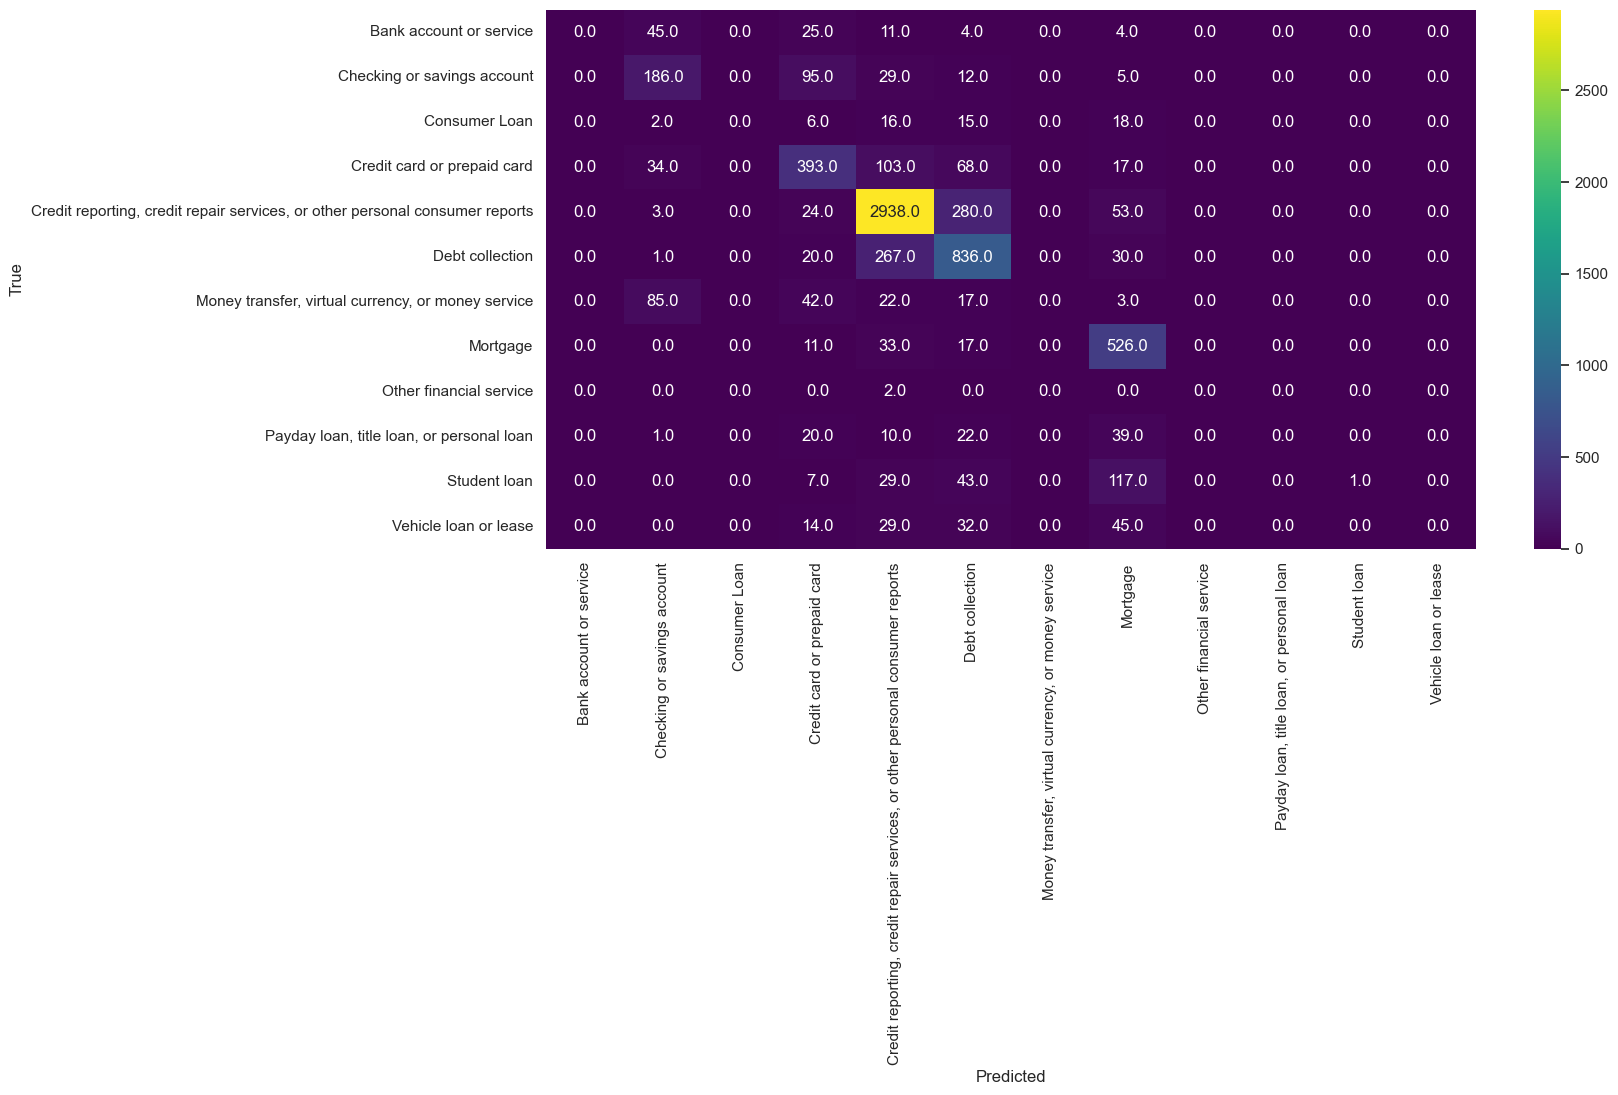

In [68]:
### View confusion matrix
from sklearn.metrics import confusion_matrix

# Get labels
preds_loaded_model = tf.argmax(pred_probs_loaded_model, axis=1)

# Calculate confusion matrix
cm_loaded_model = confusion_matrix(y_test_enc, preds_loaded_model)

# Plot confusion matrix
plt.figure(figsize=(15,7))
ax = sns.heatmap(cm_loaded_model,
            annot=True,
            fmt=".1f",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='viridis')
ax.set(ylabel='True', xlabel='Predicted')

Observations:
* There are some classes that it is not predicting at all (bank account or service, consumer loan, credit card, etc.)

Improvements:
* Better model could be use (transformer)
* Data points can be categorized in a better fashion